Baby's First Reinforcement Learning
----------------------------------------------------

In this notebook we will begin to explore the fundamentals of reinforcement learning. From Wikipedia:

**Reinforcement learning (RL)** is an area of machine learning concerned with how software agents ought to take actions in an environment so as to maximize some notion of cumulative reward. (see: https://en.wikipedia.org/wiki/Reinforcement_learning)

Reinforcement learning has seen numerous successes in recent years. Groups such as OpenAI and
Google Deepmind have successfully trained agents to play Atari games 1 with super-human skill. More recently,
groups have trained agents to play considerably more complex games like Dota II. In each of these cases, the AI
agent is trained by allowing it to explore the environment, and discovering on it’s own which sequences of
actions lead to maximization of the chosen reward.

We will begin by exploring an old idea known as a **Markov Decision Process** (MDP). MDP's can be applied in reinforcement learning contexts, but as we will see they have limitations. If time allows, we will also explore **Deep Reinforcement Learning** which is a collection of newer techniques designed to overcome the limitations of MDP's by using **Neural Networks**.

In [1]:
from importlib import reload #allow us to reload custom modules any time we like with modifications
from IPython.display import clear_output #so we can iteratively update the output without filling the screen
from collections import deque #fast queue implementation
from pprint import pprint
import matplotlib.pyplot as plt
import time
import environment #custom module
import markov_decision_process #custom module
import progress_bar #custom module
reload(environment)
reload(markov_decision_process)
reload(progress_bar)

#Step 1: Set up the environment such that we can view it, modify it, determine rewards
env = environment.Environment()
print("This is what our environment looks like. The Agent 'A' needs to learn to seek out the food/reward 'R'.")
env.render()

This is what our environment looks like. The Agent 'A' needs to learn to seek out the food/reward 'R'.
----------
|R       |  
|        |  
|        |  
|        |  
|    A   |  
|        |  
|        |  
|        |  
----------


In [2]:
#Step 2: Initialize trainable MDP
mdp = markov_decision_process.MarkovDecisionProcess()
mdp.set_possible_actions(env.agent.get_possible_movement_directions())

#Define the observe->action step functionality we use during training
def train_step(env, mdp, epsilon=0.2):
    #Observe the environment (get the current state).
    state = env.get_state_vector(as_string=True) #String is easier for our MDP class to store
    
    #Given the state, select an action.
    action = mdp.get_predicted_action(state, epsilon)
    env.agent.move(action)
    
    #Determine if we got a reward. 
    reward = 0
    if env.has_agent_food_collision():
        reward = 1
        env.reset_food()
        
    return state, action, reward #This will be used by the outer training loop to encourage rewarding actions

#Observe that prior to training the MDP, our agent moves around essentially randomly
for i in range(0,10):
    train_step(env, mdp)
    clear_output()
    env.render()
    time.sleep(0.5)

----------
|R       |  
|        |  
|        |  
|        |  
|        |  
|     A  |  
|        |  
|        |  
----------


Progress: [####################] 100.0%


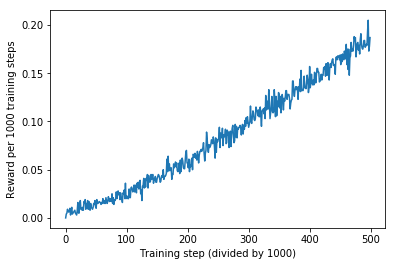

In [6]:
#Step 3: Run MDP training algorithm on the environment from step 1. Observe reward/time curve.
training_steps = 500000
initial_epsilon = 1
epsilon = initial_epsilon 
anneal_epsilon = True #do we decrease epsilon over time?
max_history_length = 10 #how many past actions do we want to encourage?
history = deque([])
progress = progress_bar.ProgressBar(total_elements=training_steps)
reward_trends = []
reward_trend_interval = 1000
cumulative_reward_trend = 0

#This is the main training loop.
for i in range(0, training_steps):
    state, action, reward = train_step(env, mdp, epsilon)
    history.append({"state": state, "action": action})
    while len(history) > max_history_length:
        history.popleft()
        
    if reward > 0:
        for sa in history:
            mdp.encourage(sa["state"], sa["action"])
        cumulative_reward_trend += reward
        
    #We just "turn down" epsilon by a linear interpolation from initial_epsilon to 0.
    if anneal_epsilon:
        epsilon_lerp = initial_epsilon / training_steps
        epsilon = epsilon - epsilon_lerp
        if epsilon < 0:
            epsilon = 0 #might happen due to floating point error stacking up?
            
    if i % reward_trend_interval == 0:
        reward_trends.append(cumulative_reward_trend / reward_trend_interval)
        cumulative_reward_trend = 0
        progress.update(i).draw()
            
progress.update(training_steps).draw()
            
plt.plot(range(len(reward_trends)), reward_trends)
plt.ylabel("Reward per 1000 training steps")
plt.xlabel("Training step (divided by 1000)")
plt.show()

In [4]:
#What does the MDP internal state->action pairs look like:
pprint(mdp.state_actions)

{'00000001': {0: 6457, 1: 6206, 2: 92421, 3: 5905},
 '00000010': {0: 2364, 1: 33307, 2: 4144, 3: 2377},
 '00000100': {0: 1064, 1: 13721, 2: 1166, 3: 1245},
 '00001000': {0: 2256, 1: 33270, 2: 2127, 3: 3957},
 '00010000': {0: 6349, 1: 6375, 2: 5864, 3: 92713},
 '00100000': {0: 33469, 1: 2330, 2: 2268, 3: 4022},
 '01000000': {0: 13396, 1: 1045, 2: 1190, 3: 1147},
 '10000000': {0: 33336, 1: 2429, 2: 4166, 3: 2434}}


In [5]:


#Observe our agent after running for a while. Does it appear to have learned anything?
for i in range(0,50):
    train_step(env, mdp, epsilon=0)
    clear_output()
    env.render()
    time.sleep(0.5)

----------
|        |  
|        |  
|        |  
|      A |  
|        |  
|        |  
|     R  |  
|        |  
----------
